In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.stats.multivariate_normal import logpdf as jlogpdf

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Question 1: Reading and formatting dataset

In [2]:
#1.1 : Read the datset with pandas
dataset = pd.read_csv("GermanCredit.txt", sep ="\s+", header=None)
dataset

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,1
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,1
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,1
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,2


In [3]:
#1.2 : creating ytrain 
dataset[24] = dataset[24] - 1
dataset

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,0
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,0
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,0
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,1


In [48]:
M = 800
d = 24
length = dataset.shape[0]
y_train = dataset.loc[:M-1, d].to_numpy()
y_test = dataset.loc[M:, d].to_numpy()

x_train = dataset.loc[:M-1, :d-1]
x_test = dataset.loc[M:, :d-1]

In [49]:
#1.3 : scaling xtrain 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape

(800, 24)

In [50]:
#1.4 : add a col of ones
ones_train = jnp.ones((M, 1))
ones_test = jnp.ones((length-M, 1))
x_train = jnp.concatenate((ones_train, x_train), axis=1)
x_train.shape

(800, 25)

In [51]:
# the shape changes to dimension 25
x_test = jnp.concatenate((ones_test, x_test), axis=1)
x_test

DeviceArray([[ 1.        ,  1.1419969 ,  0.27564564, ..., -0.14734778,
              -0.50195235,  0.7684122 ],
             [ 1.        , -0.46928617, -0.21823233, ..., -0.14734778,
               1.9922209 , -1.3013849 ],
             [ 1.        , -1.2749277 , -0.05360634, ..., -0.14734778,
              -0.50195235,  0.7684122 ],
             ...,
             [ 1.        ,  1.1419969 , -0.7121103 , ..., -0.14734778,
              -0.50195235,  0.7684122 ],
             [ 1.        , -1.2749277 ,  2.0042186 , ..., -0.14734778,
              -0.50195235,  0.7684122 ],
             [ 1.        , -0.46928617,  2.0042186 , ..., -0.14734778,
              -0.50195235,  0.7684122 ]], dtype=float32)

In [52]:
#make sure that the values are scaled 
jnp.mean(x_train, axis=0), jnp.std(x_train, axis=0)

(DeviceArray([ 1.00000000e+00,  5.36441780e-09,  3.57627861e-09,
               1.19209287e-09,  2.38418574e-09, -7.15255721e-09,
              -3.93390636e-08, -2.68220890e-09,  1.07288356e-08,
              -3.06963912e-08, -1.07288356e-08,  2.02655794e-08,
              -3.75509259e-08, -2.14576712e-08, -5.12599918e-08,
               3.87430177e-08,  1.47521488e-08,  2.38418574e-09,
               3.36766242e-08,  1.78813924e-08,  3.72529030e-09,
               0.00000000e+00,  3.57627861e-09,  2.68220894e-08,
              -1.40070915e-08], dtype=float32),
 DeviceArray([0.        , 1.0000001 , 1.        , 0.9999999 , 1.        ,
              1.        , 1.        , 1.        , 1.        , 1.        ,
              0.99999994, 1.0000001 , 0.9999999 , 1.0000001 , 0.99999994,
              0.99999994, 1.0000002 , 0.9999997 , 0.99999994, 1.        ,
              0.99999994, 1.        , 1.0000001 , 1.        , 1.0000001 ],            dtype=float32))

# Question 2: Model specification

##### 2.1 : Proof of log-odds ratio
Let us denote $$z= \beta_0 + \sum_{j = 1}^n \beta_j X_j.$$

We are to show that
$$ \log \frac{P(Y=1|\beta)}{1-P(Y=1|\beta)} = z.$$
We can rewrite the left hand side by splitting the fraction of the log
\begin{align*} 
\log \frac{P(Y=1|\beta)}{1-P(Y=1|\beta)} &=  \log \frac{1}{1+e^{-z}} - \log \frac{e^{-z}}{1+e^{-z}}\\ 
 &=   \log 1 - \log e^{-z}\\ 
 &=  - \log e^{-z}\\ 
 &= z
\end{align*}
Note that in the second step we used that you can split again to 4 logarithms and then the log of the denominators will have opposite sign.

##### 2.2 : Parameters
We can interepret these parameters as XYZ

##### 2.3 : Decision Boundry. 
Is it in terms of prob or vars >= 0?

##### 2.4 : Proof of log-likelihood
Let us denote $$z_i= \beta_0 + \sum_{j = 1}^n \beta_j X_{i,j}.$$

If $y_i = 1$, we see that the right hand side is 
\begin{align*} 
\log \frac{1}{1+e^{-z_i}}  &= \log \frac{e^z_i}{1+e^{z_i}}\\
&= z_i - \log 1+e^z_i\\
&= y_i z_i - \log 1+e^z_i.
\end{align*}

If $y_i = 0$, we see that the right hand side is 
\begin{align*} 
\log \frac{e^{-z_i}}{1+e^{-z_i}}  &= \log \frac{1}{1+e^{z_i}}\\
&= 0 - \log 1+e^{z_i}\\
&= y_i z_i - \log 1+e^{z_i}.
\end{align*}

In [53]:
#Implementation – never used
#math needed: Is there an error?

def log_likelihood(beta):
    x_beta = np.matmul(x_train, beta)
    output = np.sum(y_train * x_beta - np.log(1 + np.exp(x_beta)))
    return output


##### 2.5 : Jax-compatible log-likelihood

We are asked to calculate
$$\log P(y_1,...,y_m| \beta).$$

By independence of the training data points, this equals
$$\log \prod_{i=1}^m P(y_i| \beta).$$

We can now use the result from previous exercise to see that 

\begin{align*} 
\log \prod_{i=1}^m P(y_i| \beta) &=  \sum_{i=1}^m \log P(y_i| \beta) \\
&= \sum_{i=1}^m (y_i z_i - \log 1+e^z_i)\\
&= \sum_{i=1}^m y_i z_i -  \sum_{i=1}^m \log 1+e^z_i.
\end{align*}

In [54]:
#math and speed comparison needed
@jit
def log_likelihood_jax(beta):
    x_beta = jnp.matmul(x_train, beta)
    output = jnp.sum(y_train * x_beta - jnp.log(1 + jnp.exp(x_beta)))
    return output

# After investigation, the jit implementations speeds up significantly
jit_likelihood_jax = jit(log_likelihood_jax)

In [55]:
#2.6 : Gradient
# speed comparison needed

# Evaluates the gradient of the log likelihood for any beta
# After investigation, the jit implementations speeds up significantly
grad_log_likelihood = jit(grad(log_likelihood_jax))

DeviceArray([-125.85038 , -112.87024 ,   60.391937,  -83.41187 ,
               81.85873 , -101.69447 ,  -10.424187,  100.2832  ,
              -42.975525,   43.08242 ,  -15.274115,  -64.577225,
               61.24506 ,  -41.640305,   30.239134,  -10.612961,
               44.812675,  -42.0322  ,  -69.4035  ,   79.49324 ,
               34.5816  ,  -39.76547 ,  -23.733591,  -58.686573,
               24.8283  ], dtype=float32)

In [56]:
#2.7 : Logprior Function
#speed comparison is needed

DIM = 25
constant = jnp.pi**2 * M / (3*DIM)
Sigma = constant * jnp.linalg.inv(jnp.matmul(x_train.T, x_train))

@jit
def log_prior(beta):
    '''
    Input – beta: a vector of size d+1
    Output – log prior density: constant
    '''
    return jlogpdf(beta, mean = jnp.zeros(DIM), cov = Sigma)


# After investigation, the jit implementations does not speed up significantly
# jitlogprior = jit(logprior)

In [57]:
#2.8 : Gradient
#speed comparison is needed
grad_log_prior = jit(grad(log_prior))
grad_log_prior(beta)

DeviceArray([ 2.1491656 ,  0.5245354 , -0.95466065, -0.55552334,
              1.5547506 , -2.6611156 ,  1.8453938 ,  7.862201  ,
             -2.5415788 , -0.42106813,  0.82316023, -1.9584857 ,
              3.9196281 , -2.471919  ,  2.6135716 ,  1.2544785 ,
              0.47925758, -0.18820098, -4.4145246 ,  3.7610672 ,
              0.28254575,  0.3626024 , -1.4113926 , -2.9575057 ,
              2.1808474 ], dtype=float32)

In [58]:
# 2.9 : Create the log posterior
def log_posterior(beta):
    '''
    Input – beta: a vector of size d+1
    Output – log posterior: constant
    '''
    return log_prior(beta) + log_likelihood(beta)


In [59]:
# 2.10 : Evaluates the gradient of the unnormalized log-posterior density
 
def grad_log_posterior(beta):
    '''
    Input – beta: a vector of size d+1
    Output – gradient step of log posterior: beta: a vector of size d+1
    '''
    return grad_log_prior(beta) + grad_log_likelihood(beta)

# Section 3

In [60]:
# Q1: independent Metropolis-Hastings
def sample_prior():
    return multivariate_normal.rvs(mean=np.zeros(DIM), cov=Sigma)

n_accept = 0
N = 10000
current_beta = sample_prior()
store_beta = np.zeros((N, DIM))

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [61]:
#run the loop
for n in range(N):
    #sample a proposed state
    proposed_beta = sample_prior()

    #evaluate posterior density
    log_posterior_proposed = log_posterior(proposed_beta)
    log_posterior_current = log_posterior(current_beta)

    #evaluate transition likelihood
    log_transition_proposed = log_prior(proposed_beta)
    log_transition_current = log_prior(current_beta)
    
    #log acceptance prob
    log_accept_prob = (log_posterior_proposed + log_transition_current
                       - log_posterior_current - log_transition_proposed)

    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < log_accept_prob:
        current_beta = proposed_beta.copy() #accept
        n_accept += 1

    store_beta[n,:] = current_beta

In [62]:
print("Acceptance rate: ", n_accept/N)

Acceptance rate:  0.0006


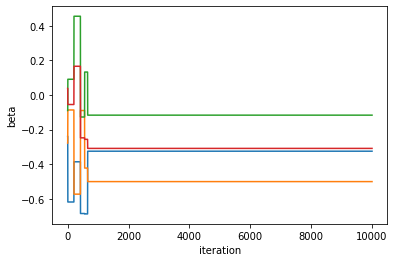

In [63]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

In [64]:
#3.2 : Random Walk Metropolis–Hastings algorithm
s = 0.02
SIG = jnp.eye(DIM) * s**2
rng = jax.random.PRNGKey(0)
n_accept = 0
store_beta = np.zeros((N,DIM))
beta = sample_prior()

for n in range(N):
#     epsilon = jax.random.multivariate_normal(key=rng, mean= jnp.zeros(DIM), cov=SIG)  
    epsilon = np.random.multivariate_normal(mean= jnp.zeros(DIM), cov=SIG)  

    proposed_state = beta + epsilon
    
    pi_y = log_posterior(proposed_state)
    pi_x = log_posterior(beta)
    
    logacceptprob = float(pi_y - pi_x)
    
    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() #accept
        n_accept += 1
    store_beta[n,:] = beta
    

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [65]:
n_accept/N

0.5687

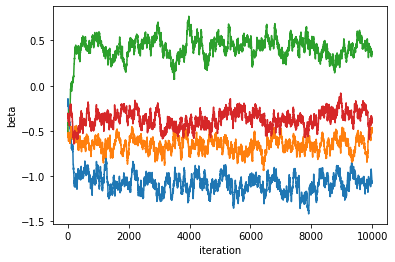

In [66]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

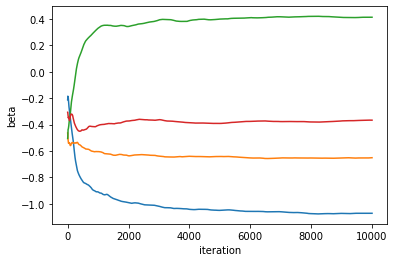

In [67]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,3])/iteration)
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

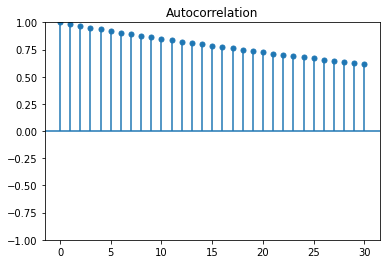

<Figure size 432x288 with 0 Axes>

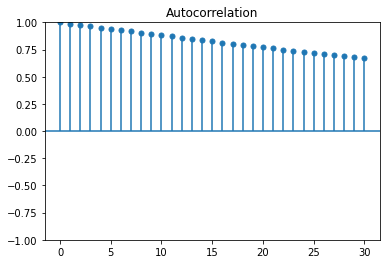

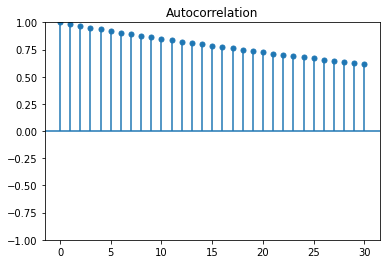

In [68]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[2000:,0], lags = 30, alpha = None)
plot_acf(store_beta[2000:,1], lags = 30, alpha = None)

In [74]:
# 3.3 : Metropolis-adjusted Langevin algorithm
import scipy
s = 0.08
SIG = jnp.eye(DIM) * s**2
rng = jax.random.PRNGKey(0)
n_accept = 0
store_beta = np.zeros((N,DIM))
beta = sample_prior()

for n in range(N):
#     epsilon = jax.random.multivariate_normal(key=rng, mean= jnp.zeros(DIM), cov=SIG)    
    epsilon = np.random.multivariate_normal(mean= jnp.zeros(DIM), cov=SIG)    
    
    proposed_state = beta + s**2 /2 * grad_log_posterior(beta) + epsilon
    
    pi_y = log_posterior(proposed_state)
    pi_x = log_posterior(beta)
    q_y = jlogpdf(proposed_state, mean = beta + s**2 /2 \
                                                 * grad_log_posterior(beta) , cov=SIG)
    q_x = jlogpdf(beta , mean = proposed_state + s**2 /2 \
                                                 * grad_log_posterior(proposed_state) , cov=SIG)
    
    
    
    logacceptprob = float(pi_y + q_x - pi_x - q_y)
    
    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() #accept
        n_accept += 1
    store_beta[n,:] = beta
    

In [75]:
n_accept/N

0.479

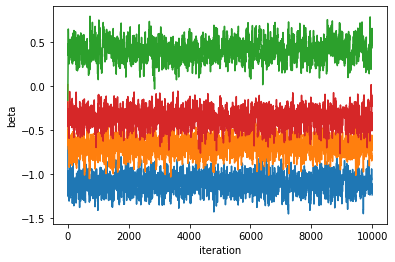

In [76]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

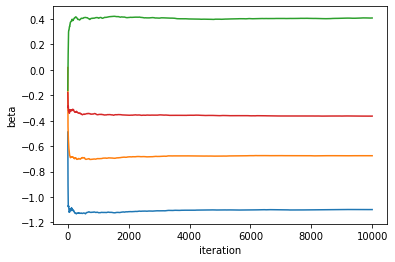

In [77]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,3])/iteration)
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

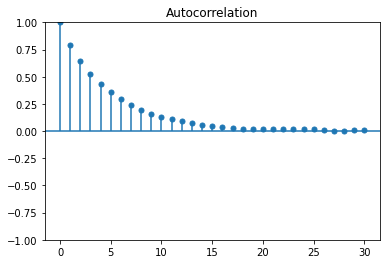

<Figure size 432x288 with 0 Axes>

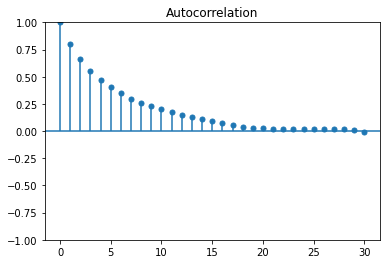

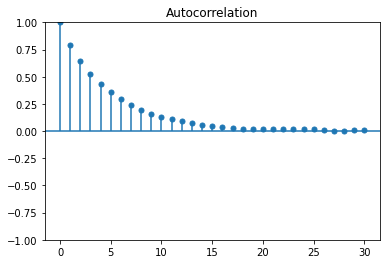

In [78]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[2000:,0], lags = 30, alpha = None)
plot_acf(store_beta[2000:,1], lags = 30, alpha = None)

In [95]:
#3.4 : Hamiltonian Monte Carlo algorithm
import numpy as np
from hmc import hamiltonian_dynamics

s = 0.08
SIG = jnp.eye(DIM) * s**2
n_accept = 0
store_beta = np.zeros((N,DIM))
beta = sample_prior()

# Hamiltonian Monte Carlo, achieve both large move and decent acceptance prob
step_size_list = [0.01, 0.05, 0.1]
D = 25
number_step_list = [5,10]
for step_size in step_size_list:
    for number_step in number_step_list:
        # initialize the Markov Chain
        beta = sample_prior()

        store_beta = np.zeros((N,D))
        counter = 0
        for n in range(N):
            velocity = scipy.stats.multivariate_normal.rvs(mean=np.zeros(D), cov=np.identity(D))
            # (1). sample proposed state
            proposed_state, proposed_velocity = hamiltonian_dynamics(beta,velocity,step_size,number_step,grad_log_posterior)

            # (3). evaluate posterior densities
            logprior_proposed = log_posterior(proposed_state)
            logprior_current = log_posterior(beta)
            numerator = jlogpdf(proposed_velocity,mean=jnp.zeros(D),cov=np.identity(D))
            denominator = jlogpdf(velocity,mean=jnp.zeros(D),cov=np.identity(D))
            # (4). log-acceptance prob
            logacceptprob = float(logprior_proposed + numerator  - logprior_current - denominator)
            # 5). accept or reject
            uniform = np.random.rand(1) # sample a uniform on [0,1]
            if np.log(uniform) < logacceptprob:
                beta = proposed_state.copy() # accepting, otherwise, stay same beta
                counter += 1
            # 6). store states
            store_beta[n,:] = beta


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [96]:

print (step_size,number_step,counter/N)

0.1 10 0.227


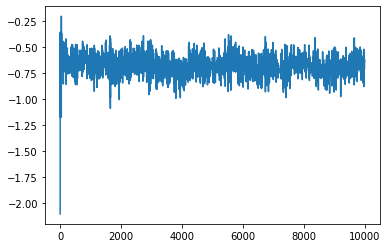

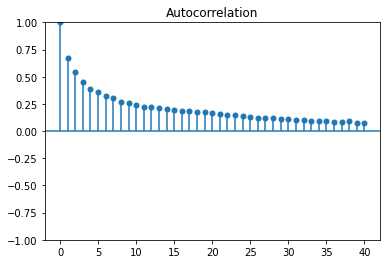

In [97]:

# trace plots, should look like stationarity
plt.figure()
plt.plot(range(N),store_beta[:,1]) # the second dimension
plt.show()
# auto-correlation, should go down very quickly to 0
plot_acf(store_beta[:,1], alpha=None)
plt.show()

# Section 4

##### 4.1
Under the integral, we can see the expit function and a probability distribution. To estimate this integral, we sample $N$ points $\{ \beta^{(t)}, \space t \in \{1, .. , N\} \space \}$ from the distribution $P(\beta | y_1,..,y_m)$ and then add the obtained values $$\text{expit}(z^{(t)})$$ where 
$$z^{(t)}= \beta_0^{(t)} + \sum_{j = 1}^n \beta_j^{(t)} X_{j}.$$
We give every point $\beta^{(t)}$ a weight of $1/N$ so that the total weight is 1 and equals the integral of the probability function. This way, we obtain the method of the project.

In [ ]:
#4.2 : Approximated predictive probabilities

In [ ]:
#4.3 : Prediction rule

In [ ]:
#4.4 : Misclassification rate

In [ ]:
# 4.5 : Cost function

def adjust(y_test, y_pred):
    '''
    Input – y_test: vector with good/bad credit risk
          – y_pred: pred values for good/bad credit risk
    Output – average cost – constat'''
    f = lamda x,y:  5 if x==0 and y==1\
                    else 1 if x==1 and y==0 \
                    else 0
    vf = np.vectorize(f)
    return vf(y_test, y_pred)


def average_cost(y_test):
    '''
    Input – y_test: vector with good/bad credit risk
    Output – average cost – constat''' 
    return jnp.sum(y_test)

In [ ]:
#4.6 : Maximum Likelihood Estimator

In [ ]:
#4.7 : Misclassification rate

In [ ]:
#4.8 : Prediction accuracy